In [62]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [37]:
vgg = scipy.io.loadmat('bestofgiro2022_vggfeatures.mat')["features"]
skeletons = scipy.io.loadmat('bestofgiro2022_skeletons.mat')["skeldata"]
clip = scipy.io.loadmat('bestofgiro2022_clipfeatures.mat')["features"]

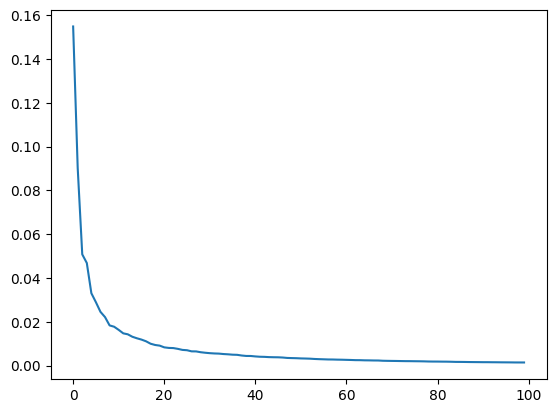

In [34]:
pca = PCA(n_components=100, svd_solver='full')
pca.fit(vgg.T)

plt.plot(pca.explained_variance_ratio_)
plt.show()

In [35]:
pca = PCA(n_components=2, svd_solver='full')
vgg_2comp = pca.fit_transform(vgg.T)

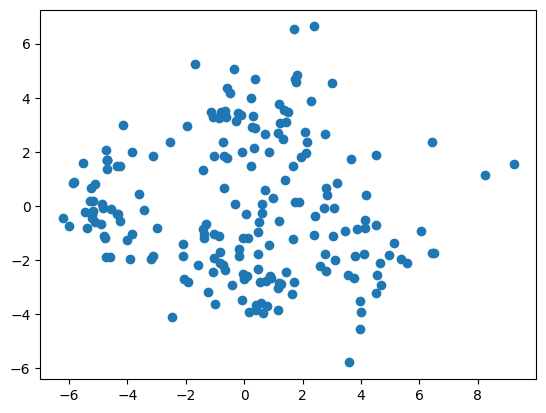

In [61]:
index = np.random.choice(vgg_2comp.shape[0], 200, replace=False)
plt.scatter(x=vgg_2comp[index,0], y=vgg_2comp[index,1])
plt.show()

In [85]:
pca = PCA(n_components=0.8, svd_solver='full')
vgg_80 = pca.fit_transform(vgg.T)

dbscan = DBSCAN(eps=0.2)
clustering = dbscan.fit_predict(vgg_80)

In [86]:
np.unique(clustering)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [87]:
vgg_80.shape

(13971, 62)